# Report 2: Theft Over Open Data (TOOD)

> This file is intended to be used as references for sections 3 - 5 which all involves model training, 
> testing, and deployment of the model. Creativity and innovation are encouraged for this and other 
> sections moving forward.

**What is the purpose of this file?**

This notebook will be covering parts 3-5 of the assignment namely going over the following:
1. Predictive Model Building - Building the Predictive Model using Modules within `sklearn`.
2. Model Scoring and Evaluation - Evaluation and Scoring of the Model with Training Data.
3. Model Deployment - Deployment of the model as `.pkl` files.

**NOTE**: The naming of this notebook is intentionally, as it stands for the following:
- `c309` - This is the course code COMP309.
- `r2` - This is the report number which is report 2 of the group project.
- `toodu` - This is the name of the dataset we named and will continue working with in this notebook.
- `model` - This is just a generic name but this notebook will contain sections 3 - 5 which all involves model training, testing, and deployment of the model.

**NOTE**: Provided below is a notebook that includes the above sections, thoroughly covering all aspects of sections 3-5. When required, there will be additional informaiton and insights throughout the notebook to help understand the specifics of the model, algorithms used, and how we handle imbalanced data when training the model.

In [2]:
import os
import json
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DEFAULT_DATA_PATH = os.path.join(os.pardir, "data")

toodu_ft_df = pd.read_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Open_Data_Cleaned.csv"))

**Observation**: The Theft Over Dataset has a noticeable glaring issue, in that much of its data for different offense overlaps with others making it hard to predict them. As such a decision was made to merge the 6 smaller offence 
types into Theft Over. This is because many of them are already classified as sub categories of Theft Over. This Dataset sorts into 3 `UCR_CODE` categories. One is for `Theft Over`, the 2nd for `Motor Vehicle Over` and the 3rd for `Shoplifting`. `Shoplifting` however as well, shares many similarities to `Theft Over`, it's difference being that it is a theft attempted from an open retail store of merchandise. However, the two would often target the same types of locations, and the difference in charge is not a meaningful difference from `Theft Over` itself. The only one that truly differentiates itself is Theft From Motor Vehicle Over, the rest almost always being theft from similar locations.

**Observation (Continue):** When it comes to features, while many columns appeared as though they would be useful such as using the latitude and longitude columns, or the neighbourhood codes, we found that while when included these had a higher importance than `PREMISES_CODE` or `LOCATION_CODE`, they were also a negative impact on the ability of the model to predict the outcome properly. This appears to be because it would then attempt to associate a neighbourhood with a type of crime which resulted in many improper predictions. However, adding another feature could then cause the model to basically ignore those high importance features. We found that these two features we went with, were the most relevant, and were the features that consistently didn't swing back and forth on importance and stayed very consistent between different feature combinations.

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

theft_over_categories = {
    "Theft - Misapprop Funds Over",
    "Theft Over - Bicycle",
    "Theft Over - Distraction",
    "Theft Over",
    "Theft Over - Shoplifting",
    "Theft Of Utilities Over",
    "Theft From Mail / Bag / Key"
}

toodu_ft_df["OFFENCE"] = toodu_ft_df["OFFENCE"].replace(theft_over_categories, "Theft Over")

le = LabelEncoder()
toodu_ft_df["OFFENCE_ENCODED"] = le.fit_transform(toodu_ft_df["OFFENCE"])

categorical_features = [
    "PREMISES_TYPE",
    "LOCATION_TYPE"
]
label_encoders = {}

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    toodu_ft_df[col] = label_encoders[col].fit_transform(toodu_ft_df[col])

In [5]:
features_filtered = toodu_ft_df[categorical_features]
features_filtered

,PREMISES_TYPE,LOCATION_TYPE
0,1,17
1,5,33
2,1,17
3,0,0
4,1,17
...,...,...
13951,4,18
13952,1,17
13953,5,24
13954,0,0


In [6]:
target_filtered = toodu_ft_df["OFFENCE_ENCODED"]
target_filtered

0        1
1        1
2        1
3        1
4        1
        ..
13951    1
13952    1
13953    0
13954    1
13955    1
Name: OFFENCE_ENCODED, Length: 13956, dtype: int32

In [7]:
scaler = StandardScaler()

numerical_features_sf = scaler.fit_transform(features_filtered)
numerical_features_sf

array([[-0.72412973, -0.11482834],
       [ 1.35806962,  1.22334337],
       [-0.72412973, -0.11482834],
       ...,
       [ 1.35806962,  0.47062179],
       [-1.24467957, -1.53663577],
       [ 0.83751978,  0.72152898]])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(numerical_features_sf, target_filtered, test_size=0.2, random_state=42)

In [32]:
!pip install imbalanced-learn

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# NOTE: We can use a better `sampling_strategy` than just "auto"
smote = SMOTE(random_state=42, sampling_strategy="auto")
x_train, y_train = smote.fit_resample(x_train, y_train)

In [10]:
SAMPLES_PER_CLASS = 1500

unique_classes = np.unique(y_train).tolist()
sampling_strategy = {cls: min(SAMPLES_PER_CLASS, (y_train == cls).sum()) for cls in unique_classes}

under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)

In [11]:
# NOTE: Start of Model Creating and Training

# Model: LogisticRegression
# NOTE: Also can add the following: n_jobs=5, C=100 | C=0.01
model = LogisticRegression(solver="liblinear", random_state=42)
model.fit(x_train, y_train)

# Model: DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=42)
model_dt.fit(x_train, y_train)

# Model: RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(x_train, y_train)

score_model = lambda model, x_test, y_test: model.score(x_test, y_test)

In [12]:
# Score Model: LogisticRegression
score_model(model, x_test=x_test, y_test=y_test)

0.7707736389684814

In [13]:
# Score Model: DecisionTreeClassifier
score_model(model_dt, x_test=x_test, y_test=y_test)

0.8151862464183381

In [14]:
# Score Model: RandomForestClassifier
score_model(model_rfc, x_test=x_test, y_test=y_test)

0.8159025787965616

In [15]:
def check_model_json_exists(existing_models, model_name):
    return any(m.get("model") == model_name for m in existing_models)

In [16]:
# NOTE: Start of Model Scoring and Evaluation (Classification Reports)
from sklearn.metrics import classification_report, accuracy_score
import pickle

SAVE_DIR = os.path.join(os.pardir, "models", "")

def evaluate_and_save_model(model, x_train, x_test, y_train, y_test, file_name):
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:10]
    
    y_pred_inverse = le.inverse_transform(y_pred)
    y_test_inverse = le.inverse_transform(y_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    file_path = os.path.join(SAVE_DIR, file_name)
    models_json_path = os.path.join(SAVE_DIR, "models.json")

    
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    
    model_metadata = {
        "model": model.__class__.__name__,
        "accuracy": accuracy,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }
    
    
    try:
        if os.path.exists(models_json_path) and os.path.getsize(models_json_path) > 0:
            with open(models_json_path, "r") as file:
                existing_models = json.load(file)
            
        else:
            existing_models = []

        if not check_model_json_exists(
                existing_models=existing_models, 
                model_name=model.__class__.__name__):
            existing_models.append(model_metadata)
        
        with open(models_json_path, "w") as file:
            json.dump(existing_models, file, indent=4)
            
        with open(file_path, "wb") as file:
            pickle.dump(model, file)
            
    except Exception as e:
        print(f"Error Occurred: {e}")

    print(f"""
    Model: {model.__class__.__name__}
    Accuracy: {accuracy:.4f}
    Training Accuracy: {model.score(x_train, y_train)}
    Classification Report: {classification_report(y_test, y_pred)}
    Predictions: {y_pred_inverse}
    Prediction Probabilities: {y_pred_proba}
    Y Values: {y_test.value_counts()}
    ----
    Model Saved To: {file_path}
    Model Metadata Added To: {models_json_path}
    """)

In [59]:
# Save Model: LogisticRegression
evaluate_and_save_model(model=model, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="lr_model.pkl")


    Model: LogisticRegression
    Accuracy: 0.7708
    Training Accuracy: 0.739
    Classification Report:               precision    recall  f1-score   support

           0       0.53      0.68      0.60       700
           1       0.88      0.80      0.84      2092

    accuracy                           0.77      2792
   macro avg       0.71      0.74      0.72      2792
weighted avg       0.80      0.77      0.78      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ...
 'Theft From Motor Vehicle Over' 'Theft Over' 'Theft Over']
    Prediction Probabilities: [[0.25824655 0.74175345]
 [0.21030188 0.78969812]
 [0.21030188 0.78969812]
 [0.24253091 0.75746909]
 [0.79397944 0.20602056]
 [0.21030188 0.78969812]
 [0.21030188 0.78969812]
 [0.45521018 0.54478982]
 [0.14985842 0.85014158]
 [0.76822739 0.23177261]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\lr_model.pkl
    Model Metadata Added To: ..\mod

In [60]:
# Save Model: DecisionTreeClassifier
evaluate_and_save_model(model=model_dt, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="dt_model.pkl")


    Model: DecisionTreeClassifier
    Accuracy: 0.8152
    Training Accuracy: 0.7776666666666666
    Classification Report:               precision    recall  f1-score   support

           0       0.62      0.67      0.65       700
           1       0.89      0.86      0.87      2092

    accuracy                           0.82      2792
   macro avg       0.75      0.77      0.76      2792
weighted avg       0.82      0.82      0.82      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ...
 'Theft From Motor Vehicle Over' 'Theft Over' 'Theft Over']
    Prediction Probabilities: [[0.04       0.96      ]
 [0.23234201 0.76765799]
 [0.23234201 0.76765799]
 [0.         1.        ]
 [0.89441748 0.10558252]
 [0.23234201 0.76765799]
 [0.23234201 0.76765799]
 [0.48218527 0.51781473]
 [0.12365591 0.87634409]
 [0.70380435 0.29619565]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\dt_model.pkl
    Model Metadata

In [61]:
# Save Model: RandomForestClassifier
evaluate_and_save_model(model=model_rfc, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="rf_model.pkl")


    Model: RandomForestClassifier
    Accuracy: 0.8159
    Training Accuracy: 0.7776666666666666
    Classification Report:               precision    recall  f1-score   support

           0       0.62      0.67      0.65       700
           1       0.89      0.86      0.88      2092

    accuracy                           0.82      2792
   macro avg       0.76      0.77      0.76      2792
weighted avg       0.82      0.82      0.82      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ...
 'Theft From Motor Vehicle Over' 'Theft Over' 'Theft Over']
    Prediction Probabilities: [[0.03667035 0.96332965]
 [0.23197316 0.76802684]
 [0.23197316 0.76802684]
 [0.         1.        ]
 [0.89726041 0.10273959]
 [0.23197316 0.76802684]
 [0.23197316 0.76802684]
 [0.48006186 0.51993814]
 [0.12183222 0.87816778]
 [0.70507433 0.29492567]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\rf_model.pkl
    Model Metadata

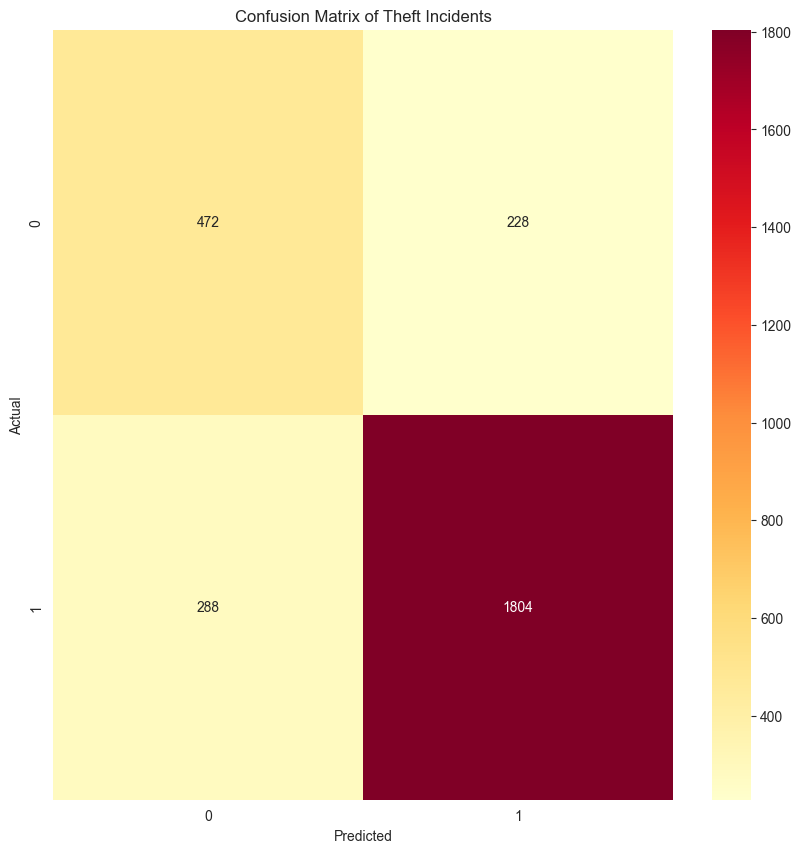

In [17]:
# NOTE: Start of Confusion Matrix and Visualizations
from sklearn.metrics import confusion_matrix

# TODO: Fix this Confusion Matrix!

y_pred_dt = model_dt.predict(x_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_dt, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# TODO: Fix this Confusion Matrix!

y_pred_rfc = model_rfc.predict(x_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_rfc, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

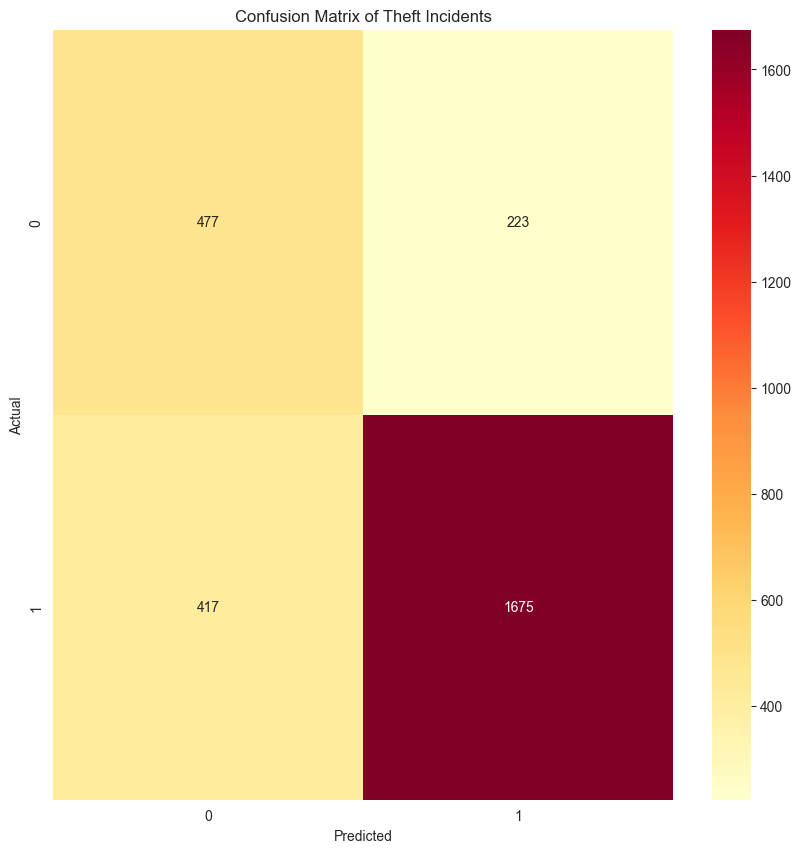

In [18]:
# TODO: Fix this Confusion Matrix!

y_pref = model.predict(x_test)
cm = confusion_matrix(y_test, y_pref)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
# NOTE: Classification Metrics Function to Calculate Metrics

def calculate_classification_metrics(TP, TN, FP, FN):
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    precision_score = TP / float(TP + FP)
    recall_score = TP / float(TP + FN)
    true_positive_rate = TP / float(TP + FN)
    false_positive_rate = FP / float(FP + TN)
    
    print(f"""
    Classification Accuracy: {classification_accuracy}
    Classification Error:    {classification_error}
    Precision Score:         {precision_score}
    Recall Score:            {recall_score}
    True Positive Rate:      {true_positive_rate}
    False Positive Rate:     {false_positive_rate}
    """)

In [66]:
# Classification Metrics for Decision Tree Classifier
calculate_classification_metrics(
    TP=cm_dt[0, 0],
    TN=cm_dt[1, 1],
    FP=cm_dt[0, 1],
    FN=cm_dt[1, 0]
)


    Classification Accuracy: 0.8151862464183381
    Classification Error:    0.18481375358166188
    Precision Score:         0.6742857142857143
    Recall Score:            0.6210526315789474
    True Positive Rate:      0.6210526315789474
    False Positive Rate:     0.11220472440944881
    


In [67]:
# Classification Metrics for Random Forest Classifier
calculate_classification_metrics(
    TP=cm_rfc[0, 0],
    TN=cm_rfc[1, 1],
    FP=cm_rfc[0, 1],
    FN=cm_rfc[1, 0]
)


    Classification Accuracy: 0.8159025787965616
    Classification Error:    0.1840974212034384
    Precision Score:         0.6742857142857143
    Recall Score:            0.6226912928759895
    True Positive Rate:      0.6226912928759895
    False Positive Rate:     0.11209439528023599
    


In [68]:
# Classification Metrics for Logistic Regression
calculate_classification_metrics(
    TP=cm[0, 0],
    TN=cm[1, 1],
    FP=cm[0, 1],
    FN=cm[1, 0]
)


    Classification Accuracy: 0.7707736389684814
    Classification Error:    0.22922636103151864
    Precision Score:         0.6814285714285714
    Recall Score:            0.5335570469798657
    True Positive Rate:      0.5335570469798657
    False Positive Rate:     0.11749209694415173
    


In [69]:
# NOTE: Graphviz Implementation for Decision Tree Classifier

from sklearn.tree import export_graphviz

DOT_PATH = os.path.join(os.pardir, "img")
try:  
    export_graphviz(
        model_dt, 
        out_file=os.path.join(DOT_PATH, "dt.dot"), 
        class_names=["Theft Over", "Auto Theft"],
        filled=True,
        rounded=True,
        special_characters=True
    )
except Exception as e:
    print(f"Error occured while exporting graph: {str(e)}")

In [70]:
# TODO: Feature Importances Here.
# TODO: ROC (Receiver Operation Characteristics) Curve Here.
# TODO: ORGANIZE EVERYTHING INTO THEIR SEPARATE SECTIONS!!! (SECTIONS 3 - 5)
# TODO: Anything Else thats Missing?

In [42]:
toodu_ft_df.to_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Data_Cleaned_Encoded.csv"), index=False)